In [1]:
import sys, subprocess
from pathlib import Path

Path("lectures/DLN-2025W/assignments/MAR/MARBLE/data").mkdir(parents=True, exist_ok=True)

subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "pip"])

subprocess.check_call([
    sys.executable, "-m", "pip", "install",
    "--no-cache-dir", "--force-reinstall",
    "numpy==1.26.4", "scipy==1.11.4",
])

subprocess.check_call([
    sys.executable, "-m", "pip", "install",
    "matplotlib==3.8.4", "matplotlib-inline==0.1.7",
    "neo", "elephant", "quantities", "mat73",
])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 117.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 85.0 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4━━━━━ 0/2 [numpy]
  Attempting uninstall: scipy━━━━━━━━━━━━━━━━━━━ 0/2 [numpy]
    Found existing installation: scipy 1.11.4 0/2 [numpy]
    Uninstalling scipy-1.11.4:0m╺━━━━━━━━━━━━━━━━━━━ 1/2 [scipy]
      Successfully uninstalled scipy-1.11.4━━━━━━━━━━━━━━━━━━━ 1/2 [scipy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scipy]32m1/2 [scipy]


0

In [2]:
import numpy, scipy
print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)

numpy: 1.26.4
scipy: 1.11.4


In [3]:
#%load_ext autoreload
#%autoreload 2
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mat73
import pickle

import MARBLE
from MARBLE import plotting

from sklearn.decomposition import PCA

import neo
from elephant.statistics import instantaneous_rate
from elephant.kernels import GaussianKernel
from quantities import ms

/home/jovyan/lectures/DLN-2025W/assignments/MAR/MARBLE/_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
from pathlib import Path

print("CWD:", os.getcwd())

Path("data").mkdir(exist_ok=True)

!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963157 -O data/conditions_spiking_data.mat


CWD: /home/jovyan/lectures/DLN-2025W/assignments/MAR/MARBLE/examples/macaque_reaching
File ‘data/conditions_spiking_data.mat’ already there; not retrieving.


In [5]:
# load data compiled into matlab cell array
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963157 -O data/conditions_spiking_data.mat
spiking_data = mat73.loadmat('data/conditions_spiking_data.mat')['all_results']

File ‘data/conditions_spiking_data.mat’ already there; not retrieving.


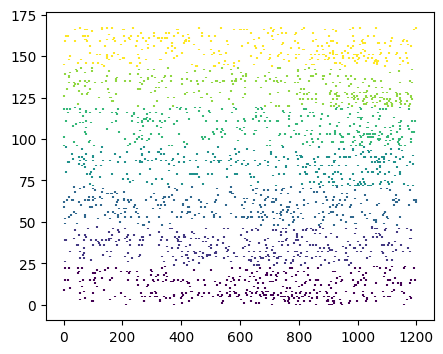

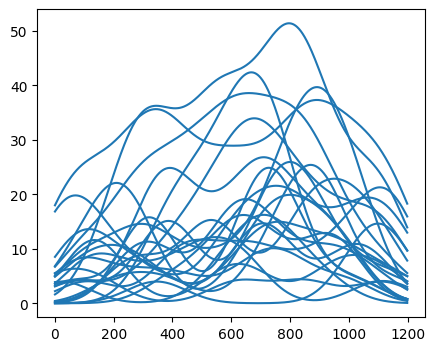

In [6]:
trial = 1
session = 9

spikes, colors = [], []
for cond in range(7):
    st = spiking_data[session][cond][trial][0][:,:]
    spikes += [np.where(st[ch,:])[0] for ch in range(24)]
    colors += [cm.viridis(cond / 6) for _ in range(24)]

_, ax = plt.subplots(figsize=(5,4))
ax.eventplot(spikes, color=colors)

_, ax = plt.subplots(figsize=(5,4))
gk = GaussianKernel(100 * ms) # increase this for smoother signals (previously used auto)

for sp in spikes[:24]:
    st = neo.SpikeTrain(sp, units='ms', t_stop=1200)
                        
    inst_rate = instantaneous_rate(st, kernel=gk, sampling_period=1 * ms).magnitude
    ax.plot(inst_rate, 'C0')

In [7]:
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7062086 -O data/raw_data_session_9_3D.pkl
pos, vel, time, _ = pickle.load(open('data/raw_data_session_9_3D.pkl','rb'))

File ‘data/raw_data_session_9_3D.pkl’ already there; not retrieving.


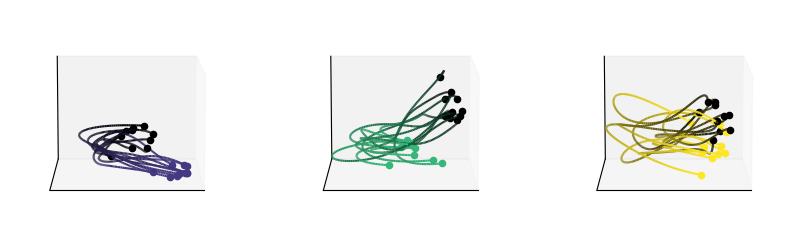

In [8]:
fig = plt.figure(figsize=(10,5))
n_traj=10
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d.art3d import Line3DCollection

for i,cond in enumerate([1,4,6]):
    ax = fig.add_subplot(int('13{}'.format(i+1)), projection='3d')
    ax.view_init(elev=10., azim=90)
    starts = np.where(time[cond]==0)[0]
    for j in range(n_traj):
        t = range(starts[j], starts[j+1]-1)
        p = pos[cond][t]
        segments = np.stack([p[:-1], p[1:]], axis=1)
        
        colors = [(0, 0, 0), cm.viridis(cond/6)] # first color is black, last is red
        cmap = LinearSegmentedColormap.from_list("Custom", colors, N=len(time[cond][t]))
        r = cmap(np.linspace(0,1,len(time[cond][t])))
        
        ax.add_collection(Line3DCollection(segments,colors=list(r)))
        ax.set_xlim([min(pos[cond][:,0]), max(pos[cond][:,0])])
        ax.set_ylim([min(pos[cond][:,1]), max(pos[cond][:,1])])
        ax.set_zlim([min(pos[cond][:,2]), max(pos[cond][:,2])])
        
        ax.scatter(pos[cond][starts[j],0],pos[cond][starts[j],1],pos[cond][starts[j],2],color=colors[0])
        ax.scatter(pos[cond][starts[j+1]-1,0],pos[cond][starts[j+1]-1,1],pos[cond][starts[j+1]-1,2],color=colors[1])
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_zaxis().set_ticks([])

In [9]:
data = MARBLE.construct_dataset(pos, vel, graph_type='cknn', k=10, local_gauges=False, number_of_eigenvectors=200) 


---- Embedding dimension: 3
---- Signal dimension: 3
---- Computing kernels ... 
---- Computing spectrum with 200 eigenvectors...

/home/jovyan/lectures/DLN-2025W/assignments/MAR/MARBLE/_env/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)


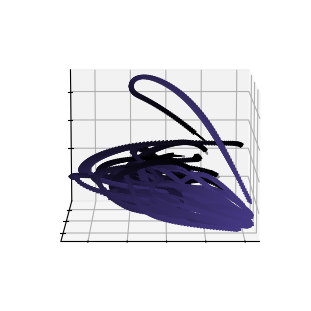

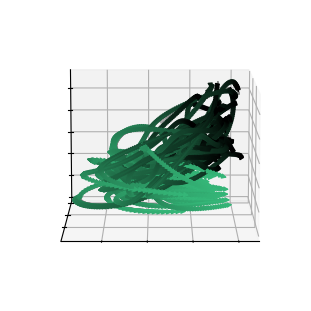

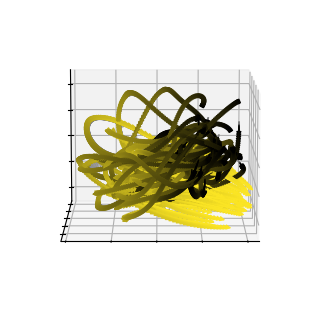

In [10]:
data_plot = data.to_data_list()
for i in [1,4,6]:
    d = data_plot[i]
    c = [(0, 0, 0), cm.viridis(i/6)] # first color is black, last is Ci
    cmap = LinearSegmentedColormap.from_list("Custom", c, N=140)
    ind = np.linspace(0,1,140)
    colors = cmap(ind[time[i][d.sample_ind].astype(int)])
    plotting.fields([d], view=(10,90), figsize=(3,3), scale=2, width=7., color=colors, axes_visible=False)
    plt.axis('on')

In [11]:
#%cd /home/jovyan/lectures/DLN-2025W/assignments/689/elbram/MARBLE/examples/macaque_reaching
#!pwd
#!ls

In [12]:
import sys
!{sys.executable} convert_spikes_to_firing_rates.py

File ‘data/conditions_spiking_data.mat’ already there; not retrieving.
Converting spikes to rates...: 100%|████████████| 44/44 [06:44<00:00,  9.19s/it]


In [13]:
import convert_spikes_to_firing_rates as conv
conv.convert_kinematics()
!ls data

File ‘data/kinematics_lfadsSingleFromFactors.mat’ already there; not retrieving.
File ‘data/trial_ids.pkl’ already there; not retrieving.


conditions_spiking_data.mat	       rate_data_20ms.pkl
kinematics.pkl			       raw_data_session_9_3D.pkl
kinematics_lfadsSingleFromFactors.mat  trial_ids.pkl


In [14]:
%cd /home/jovyan/lectures/DLN-2025W/assignments/MAR/MARBLE/examples/macaque_reaching

import sys
!{sys.executable} run_marble.py

/home/jovyan/lectures/DLN-2025W/assignments/MAR/MARBLE/examples/macaque_reaching


/home/jovyan/lectures/DLN-2025W/assignments/MAR/MARBLE/_env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


0

---- Embedding dimension: 5
---- Signal dimension: 5
---- Computing kernels ... 
---- Computing full spectrum ...
              (if this takes too long, then run construct_dataset()
              with number_of_eigenvectors specified) 
---- Settings: 

epochs : 120
order : 2
hidden_channels : [100]
out_channels : 3
inner_product_features : False
diffusion : True
batch_size : 64
lr : 0.01
momentum : 0.9
dropout : 0.0
batch_norm : batch_norm
bias : True
frac_sampled_nb : -1
include_positions : True
include_self : True
vec_norm : False
emb_norm : False
seed : 0
dim_signal : 5
dim_emb : 5
n_sampled_nb : -1

---- Number of features to pass to the MLP:  160
---- Total number of parameters:  16604

Using device cuda:0

---- Training network ...

---- Timestamp: 20260122-161913

Epoch: 0, Training loss: 1.277550, Validation loss: 1.2097, lr: 0.0100 *
Epoch: 1, Training loss: 1.177468, Validation loss: 1.1667, lr: 0.0100 *
Epoch: 2, Training loss: 1.124101, Validation loss: 1.1004, lr: 0.010